In [1]:
import os.path
import numpy as np
import pandas as pd

from source.Files_operating import read_dataFile

shtRipper v1.3


In [2]:
interval_path = "data/intervals/"
signal_path = "data/d-alpha/"

filename = "sht44194"
F_ID = filename[-5:]

if os.path.isfile(f"data/intervals/df/{F_ID}_data.csv"):
    df = pd.read_csv(f"data/intervals/df/{F_ID}_data.csv", sep=",")
else:
    df = read_dataFile(interval_path + filename + "_exportGlobus2.dat", F_ID)
    df["ch1_marked"] = pd.Series([0] * df.shape[0])

df.head()

,t,ch1,ch1_marked
0,164.646,0.33486,2.952496e-06
1,164.647,0.29907,1.311244e-06
2,164.648,0.31952,4.258399e-07
3,164.649,0.32208,6.284797e-07
4,164.650,0.35275,7.393727e-07


In [3]:
def normalise_series(data):
    max_point, min_point, median_value = data.max(), data.min(), np.median(data)
    return (data - median_value) / abs(max_point - min_point)

Input start index [0:76000]:  0


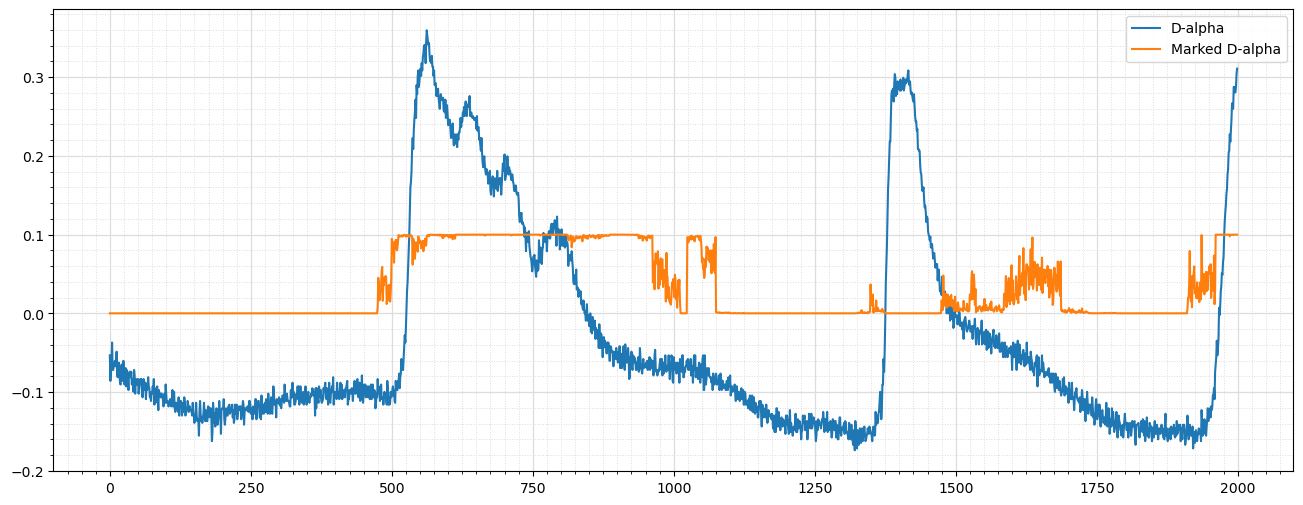

KeyboardInterrupt: Interrupted by user

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

l_edge = int(input(f"Input start index [0:{df.shape[0]//1000*1000}]: ").strip().split()[0])
step = 1500
width = 2000

while l_edge < df.shape[0]:
    fig, ax = plt.subplots()

    fig.set_figwidth(16)
    fig.set_figheight(6)

    r_edge = min(l_edge + width, df.shape[0])

    ax.plot(range(l_edge, r_edge), normalise_series(df.ch1)[l_edge:r_edge], label="D-alpha")
    # ax.plot(range(l_edge, r_edge), df.ch1_filter_norm[l_edge:r_edge], label="Filtered D-alpha")
    ax.plot(range(l_edge, r_edge), df.ch1_marked[l_edge:r_edge] / 10, label="Marked D-alpha")

    ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.legend()
    plt.show()

    res = list(map(int, input("Input index pairs of ELM fragments:\n").strip().split()))
    for i in range(0, len(res), 2):
        if (df.loc[res[i]:res[i + 1], "ch1_marked"] == 1).all():
            df.loc[res[i]:res[i + 1], "ch1_marked"] = 0
        elif (df.loc[res[i]:res[i + 1], "ch1_marked"] == 1).any():
            if input("Input y to set 1, n to set 0").lower() in ["y", "н"]:
                df.loc[res[i]:res[i + 1], "ch1_marked"] = 1
            else:
                df.loc[res[i]:res[i + 1], "ch1_marked"] = 0
        else:
            df.loc[res[i]:res[i + 1], "ch1_marked"] = 1

    plt.close()
    plt.clf()
    l_edge += step

# 275 875 925 1425 1425 1800 1800 2000

In [9]:
# df["ch1_marked"] = pd.Series([0] * df.shape[0])
df.head()
df.to_csv(f"data/intervals/df/{F_ID}_data.csv", index=False)
np.unique(df.ch1_marked.to_numpy())
# df = df.drop([4], axis=1)
# df.head()

array([0, 1], dtype=int64)

In [12]:
count = 0
for i in range(df.shape[0]-1):
    if df.iloc[i].ch1_marked == 0 and df.iloc[i+1].ch1_marked == 1:
        count += 1
print(count)

68
